<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/ML_GenerativeModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Libs

In [1]:
!pip install -q import_ipynb shap minisom

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.8 MB/s eta 0:00:00


In [2]:
# utils
import os, sys, warnings, itertools
import logging
import shap
import random
import import_ipynb
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter
from itertools import product
# colab
from google.colab import drive
# lightgbm
import lightgbm as lgb
# xgboost
import xgboost as xgb
# minisom
from minisom import MiniSom
# statsmodels
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# sklearn
from sklearn.neighbors import KNeighborsRegressor, KernelDensity
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   FunctionTransformer,
                                   MinMaxScaler)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.compose import (ColumnTransformer, make_column_transformer)
from sklearn.pipeline import (Pipeline, make_pipeline)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score)
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     cross_val_score,
                                     RandomizedSearchCV,
                                     KFold)
from sklearn.ensemble import (RandomForestClassifier,
                              RandomForestRegressor,
                              GradientBoostingClassifier,
                              GradientBoostingRegressor,
                              BaggingClassifier,
                              BaggingRegressor,
                              ExtraTreesClassifier,
                              ExtraTreesRegressor,
                              AdaBoostClassifier,
                              AdaBoostRegressor,
                              HistGradientBoostingClassifier,
                              HistGradientBoostingRegressor,
                              StackingClassifier,
                              StackingRegressor,
                              VotingClassifier)
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.neural_network import BernoulliRBM
# tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# pytorch
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# vis
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Settings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# mount google drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
# working directory
working_dir = '/content/drive/MyDrive/Jupyter Notebooks/'
os.chdir(working_dir)

In [6]:
# module dir
module_path = os.path.abspath(os.path.join("./"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [7]:
# load MachineLearningUtils module
from MachineLearningUtils import *

In [8]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid memory allocation errors
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is enabled and memory growth is set.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available.")

GPU is enabled and memory growth is set.


## Gaussian Mixture Model

### Toy Model in One Dimension

In [ ]:
# Generate synthetic 1D data
np.random.seed(42)
data = np.concatenate([
    np.random.normal(loc=-2, scale=0.5, size=300),
    np.random.normal(loc=3, scale=1.0, size=200)
    ]).reshape(-1, 1)

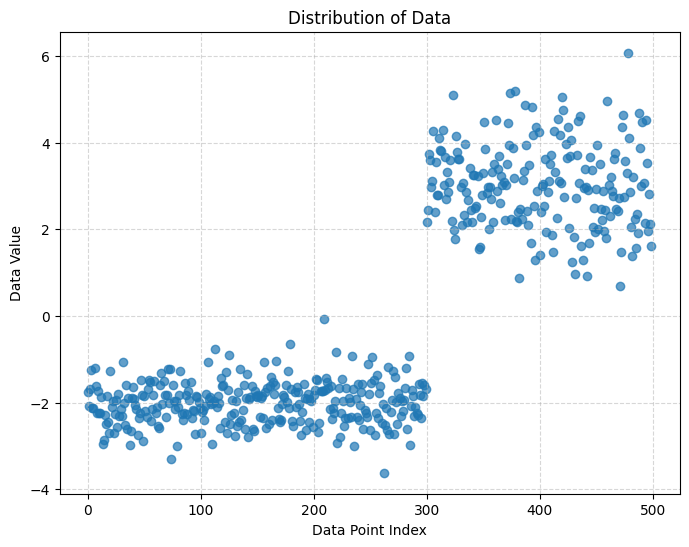

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(data)), data, marker='o', alpha=0.7)
plt.title('Distribution of Data')
plt.xlabel('Data Point Index')
plt.ylabel('Data Value')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# Fit a Gaussian Mixture Model
n_components = 2  # Number of Gaussians
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(data)

GaussianMixture(n_components=2, random_state=42)

In [ ]:
# Extract GMM parameters
means = gmm.means_.flatten()
variances = gmm.covariances_.flatten()
weights = gmm.weights_.flatten()

In [ ]:
# Define a range for plotting
x = np.linspace(data.min() - 1, data.max() + 1, 500).reshape(-1, 1)

In [ ]:
# Compute probabilities
p_x = np.exp(gmm.score_samples(x))  # Overall data density p(x)
p_x_given_z = np.array([
    (1 / np.sqrt(2 * np.pi * v)) * np.exp(-0.5 * ((x - m) ** 2) / v)
    for w, m, v in zip(weights, means, variances)
])  # Component densities p(x | z)
p_z_given_x = gmm.predict_proba(x)  # Responsibilities p(z | x)

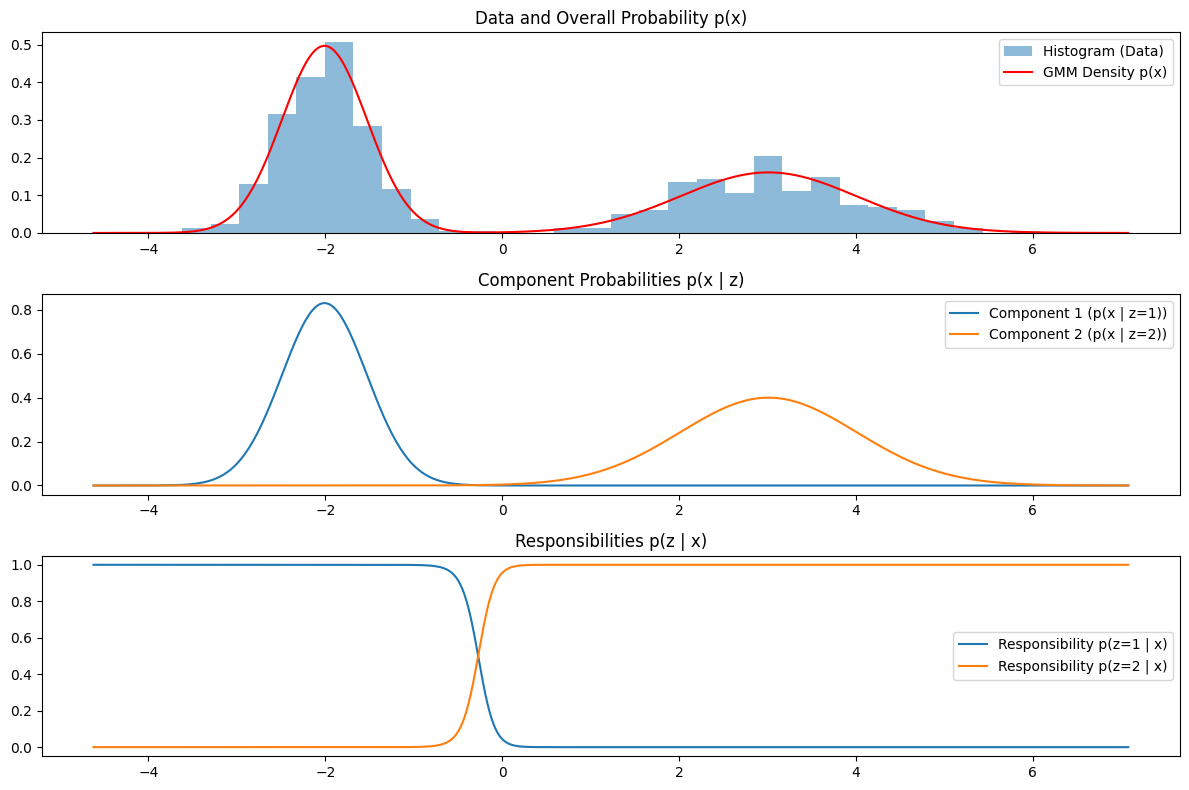

In [ ]:
# Plotting
plt.figure(figsize=(12, 8))

# 1. Data histogram and overall density
plt.subplot(3, 1, 1)
plt.hist(data, bins=30, density=True, alpha=0.5, label="Histogram (Data)")
plt.plot(x, p_x, label="GMM Density p(x)", color="red")
plt.title("Data and Overall Probability p(x)")
plt.legend()

# 2. Individual component densities
plt.subplot(3, 1, 2)
for k in range(n_components):
    plt.plot(x, p_x_given_z[k], label=f"Component {k+1} (p(x | z={k+1}))")
plt.title("Component Probabilities p(x | z)")
plt.legend()

# 3. Responsibilities
plt.subplot(3, 1, 3)
for k in range(n_components):
    plt.plot(x, p_z_given_x[:, k], label=f"Responsibility p(z={k+1} | x)")
plt.title("Responsibilities p(z | x)")
plt.legend()
plt.tight_layout()
plt.show()

### Model MNIST Dataset

In [ ]:
# Load MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0  # Normalize to [0, 1]

In [ ]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)  # Flatten for PCA and GMM

In [ ]:
# Dimensionality reduction with PCA
n_pca_components = 2
pca = PCA(n_components=n_pca_components)
x_train_pca = pca.fit_transform(x_train_flat)

In [ ]:
# Autoencoder for dimensionality reduction
latent_dim = 2  # Latent space dimension

# Define the Autoencoder
input_img = layers.Input(shape=(28, 28, 1))
x = layers.Flatten()(input_img)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
latent = layers.Dense(latent_dim, activation='relu')(x)
encoder = models.Model(input_img, latent)
decoder_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(64, activation='relu')(decoder_input)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(28 * 28, activation='sigmoid')(x)
decoded = layers.Reshape((28, 28))(x)
decoder = models.Model(decoder_input, decoded)
autoencoder = models.Model(input_img, decoder(encoder(input_img)))

In [ ]:
# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
x_train_expanded = np.expand_dims(x_train, -1)  # Add channel dimension
autoencoder.fit(x_train_expanded, x_train_expanded, epochs=10, batch_size=256, verbose=2)

Epoch 1/10
235/235 - 6s - 27ms/step - loss: 0.0743
Epoch 2/10
235/235 - 5s - 19ms/step - loss: 0.0541
Epoch 3/10
235/235 - 4s - 16ms/step - loss: 0.0499
Epoch 4/10
235/235 - 3s - 11ms/step - loss: 0.0475
Epoch 5/10
235/235 - 3s - 11ms/step - loss: 0.0461
Epoch 6/10
235/235 - 3s - 13ms/step - loss: 0.0450
Epoch 7/10
235/235 - 4s - 19ms/step - loss: 0.0442
Epoch 8/10
235/235 - 2s - 10ms/step - loss: 0.0436
Epoch 9/10
235/235 - 3s - 11ms/step - loss: 0.0430
Epoch 10/10
235/235 - 3s - 11ms/step - loss: 0.0426


In [ ]:
# Extract latent space representation
x_train_autoencoded = encoder.predict(x_train_expanded)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [ ]:
# Train GMM on both PCA and autoencoder latent spaces
gmm_pca = GaussianMixture(n_components=10, random_state=42)
gmm_autoencoded = GaussianMixture(n_components=10, random_state=42)

In [ ]:
gmm_pca.fit(x_train_pca)
gmm_autoencoded.fit(x_train_autoencoded)

GaussianMixture(n_components=10, random_state=42)

In [ ]:
# Generate new samples from PCA and autoencoder latent spaces
num_samples = 10
samples_pca, _ = gmm_pca.sample(num_samples)
samples_autoencoded, _ = gmm_autoencoded.sample(num_samples)

In [ ]:
# Reconstruct images from PCA samples
samples_pca_reconstructed = pca.inverse_transform(samples_pca).reshape(num_samples, 28, 28)

In [ ]:
# Reconstruct images from autoencoder latent space
samples_autoencoded_reconstructed = decoder.predict(samples_autoencoded).reshape(num_samples, 28, 28)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


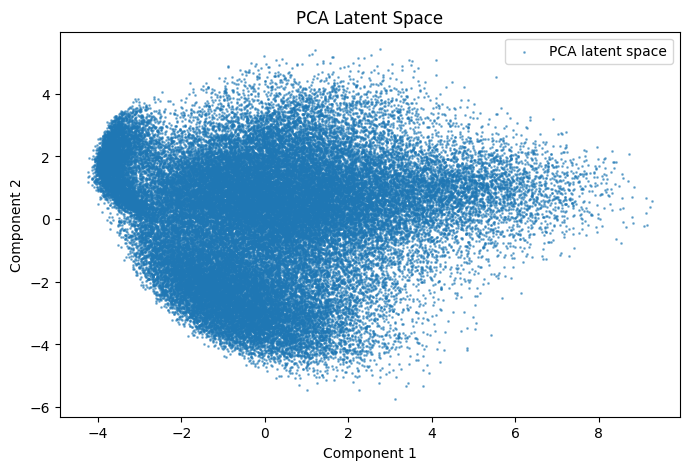

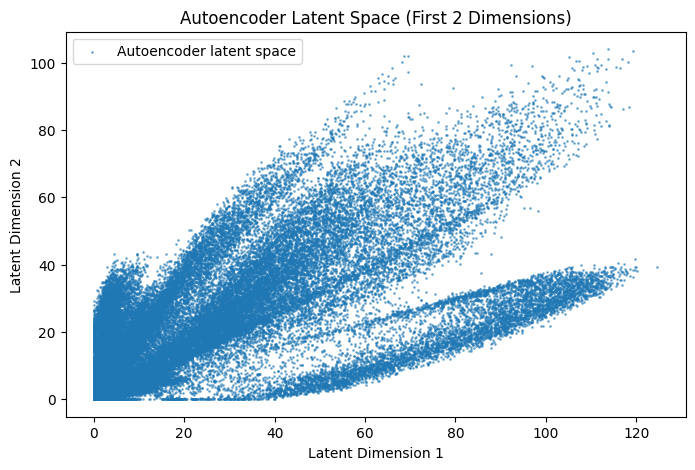

In [ ]:
# Plotting latent space (PCA)
plt.figure(figsize=(8, 5))
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], s=1, alpha=0.5, label="PCA latent space")
plt.title("PCA Latent Space")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

# Plotting latent space (Autoencoder, first 2 dimensions)
plt.figure(figsize=(8, 5))
plt.scatter(x_train_autoencoded[:, 0], x_train_autoencoded[:, 1], s=1, alpha=0.5, label="Autoencoder latent space")
plt.title("Autoencoder Latent Space (First 2 Dimensions)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.show()

In [ ]:
# Visualize generated samples
def plot_generated_samples(samples, title):
    plt.figure(figsize=(10, 5))
    for i in range(len(samples)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(samples[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

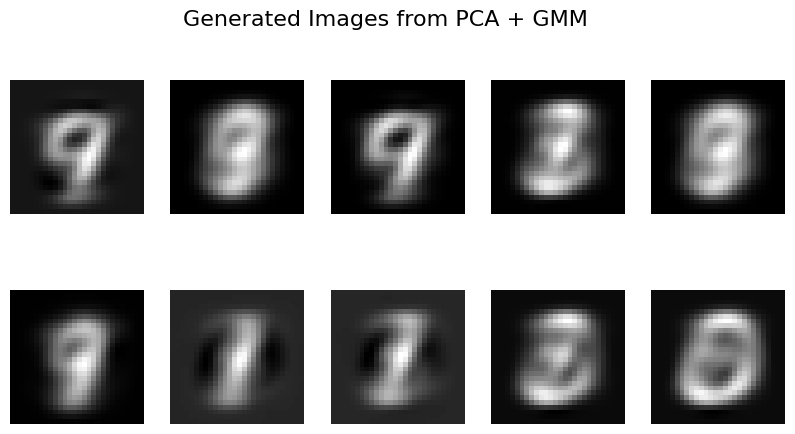

In [ ]:
plot_generated_samples(samples_pca_reconstructed, "Generated Images from PCA + GMM")

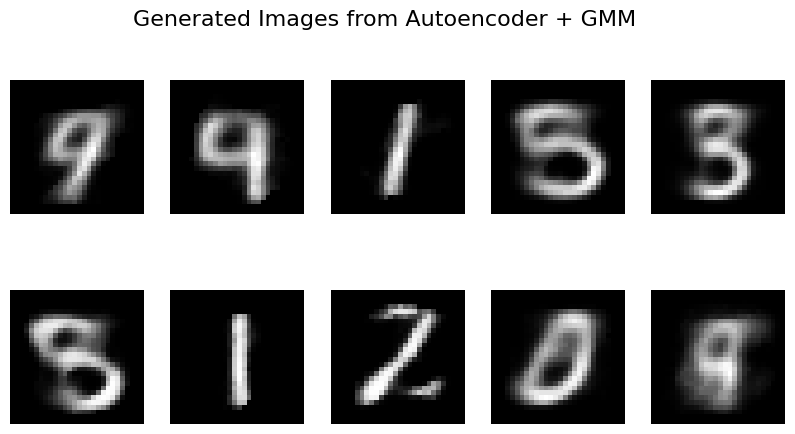

In [ ]:
plot_generated_samples(samples_autoencoded_reconstructed, "Generated Images from Autoencoder + GMM")

In [ ]:
# Generate grid for visualization
grid_x, grid_y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
grid = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)

In [ ]:
# Compute probabilities
p_x_pca = np.exp(gmm_pca.score_samples(grid)).reshape(100, 100)
responsibilities_pca = gmm_pca.predict_proba(grid).reshape(100, 100, -1)

Text(0.5, 1.0, 'PCA - Responsibility p(z=1 | x)')

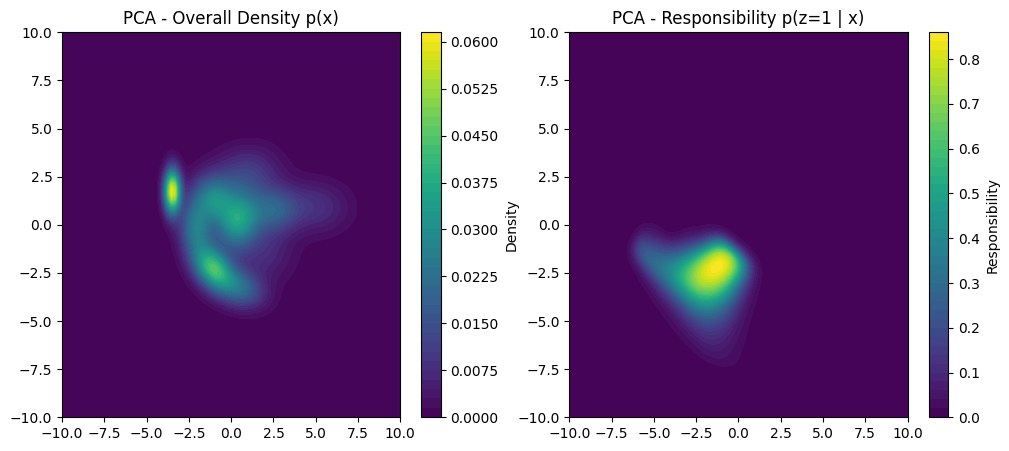

In [ ]:
# Plot the probabilities
plt.figure(figsize=(12, 5))

# PCA - Overall Density
plt.subplot(1, 2, 1)
plt.contourf(grid_x, grid_y, p_x_pca, levels=50, cmap="viridis")
plt.colorbar(label="Density")
plt.title("PCA - Overall Density p(x)")

# PCA - Responsibilities (Cluster 1)
plt.subplot(1, 2, 2)
plt.contourf(grid_x, grid_y, responsibilities_pca[..., 0], levels=50, cmap="viridis")
plt.colorbar(label="Responsibility")
plt.title("PCA - Responsibility p(z=1 | x)")

In [ ]:
# Generate grid for visualization
grid_x, grid_y = np.meshgrid(np.linspace(-100, 100, 100), np.linspace(-100, 100, 100))
grid = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)

In [ ]:
p_x_auto = np.exp(gmm_autoencoded.score_samples(grid)).reshape(100, 100)
responsibilities_auto = gmm_autoencoded.predict_proba(grid).reshape(100, 100, -1)

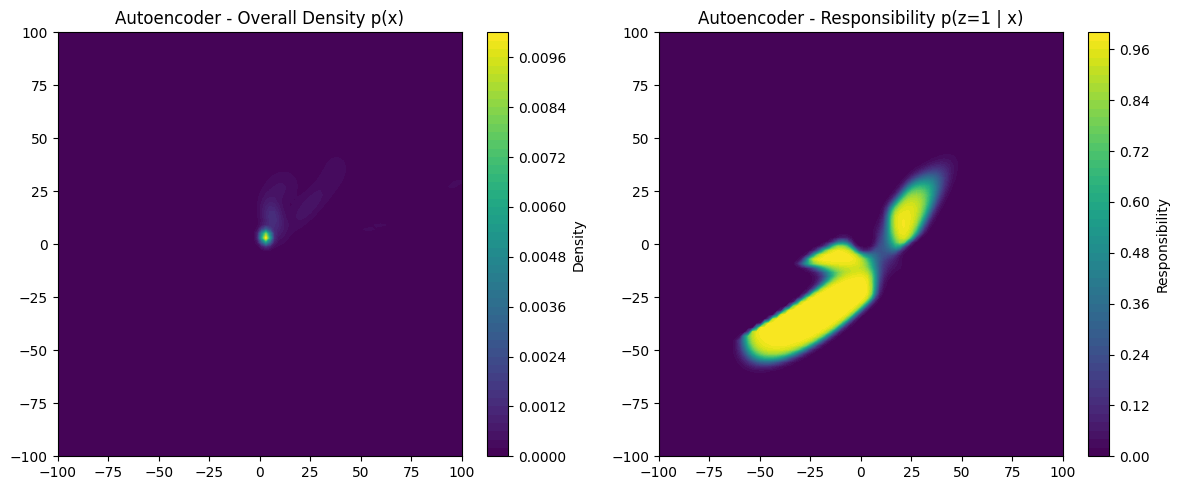

In [ ]:
# Plot the probabilities
plt.figure(figsize=(12, 5))

# Autoencoder - Overall Density
plt.subplot(1, 2, 1)
plt.contourf(grid_x, grid_y, p_x_auto, levels=50, cmap="viridis")
plt.colorbar(label="Density")
plt.title("Autoencoder - Overall Density p(x)")

# Autoencoder - Responsibilities (Cluster 1)
plt.subplot(1, 2, 2)
plt.contourf(grid_x, grid_y, responsibilities_auto[..., 0], levels=50, cmap="viridis")
plt.colorbar(label="Responsibility")
plt.title("Autoencoder - Responsibility p(z=1 | x)")

plt.tight_layout()
plt.show()

## Kernel Density Estimation

In [ ]:
# Load MNIST dataset
def load_mnist_subset(n_samples=2000):
    """Load a subset of MNIST for a specific digit."""
    mnist = fetch_openml('mnist_784', version=1)
    data, labels = mnist['data'], mnist['target']
    return data[:n_samples].values / 255.0  # Normalize to [0, 1]

In [ ]:
# Build an Autoencoder
def build_autoencoder(input_dim, latent_dim):
    """Build a simple autoencoder."""
    # Encoder
    inputs = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(128, activation='relu')(inputs)
    encoded = layers.Dense(64, activation='relu')(encoded)
    latent = layers.Dense(latent_dim, activation='linear')(encoded)

    # Decoder
    decoded = layers.Dense(64, activation='relu')(latent)
    decoded = layers.Dense(128, activation='relu')(decoded)
    outputs = layers.Dense(input_dim, activation='sigmoid')(decoded)

    # Autoencoder model
    autoencoder = models.Model(inputs, outputs)
    encoder = models.Model(inputs, latent)

    # Decoder model
    latent_inputs = layers.Input(shape=(latent_dim,))
    decoder_layer = autoencoder.layers[-3](latent_inputs)
    decoder_layer = autoencoder.layers[-2](decoder_layer)
    decoder_outputs = autoencoder.layers[-1](decoder_layer)
    decoder = models.Model(latent_inputs, decoder_outputs)

    return autoencoder, encoder, decoder

In [ ]:
# Train Autoencoder
def train_autoencoder(autoencoder, data, epochs=50, batch_size=128):
    """Train the autoencoder."""
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(data, data, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=0)

In [ ]:
# Fit KDE in latent space
def fit_kde_latent(latent_data, bandwidth=0.2):
    """Fit KDE in 2D latent space."""
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(latent_data)
    return kde

In [ ]:
# Visualize Latent Space
def plot_latent_space(latent_data, kde=None):
    """Plot the latent space and optionally overlay KDE PDF."""
    x = latent_data[:, 0]
    y = latent_data[:, 1]

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.5, s=10, label="Latent Points")

    if kde:
        # Evaluate KDE over a grid
        x_grid = np.linspace(x.min(), x.max(), 100)
        y_grid = np.linspace(y.min(), y.max(), 100)
        X, Y = np.meshgrid(x_grid, y_grid)
        grid_points = np.vstack([X.ravel(), Y.ravel()]).T
        log_pdf = kde.score_samples(grid_points)
        pdf = np.exp(log_pdf).reshape(X.shape)

        # Plot PDF as contour
        plt.contourf(X, Y, pdf, levels=50, cmap="Blues", alpha=0.7)
        plt.colorbar(label="Density")
        plt.title("Latent Space with KDE")

    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.legend()
    plt.show()

In [ ]:
# Sample and Decode
def sample_and_decode(kde, decoder, n_samples=10):
    """Sample new points in latent space and decode them back to image space."""
    samples = kde.sample(n_samples)
    decoded_images = decoder.predict(samples)
    return decoded_images

In [ ]:
# Main script
if __name__ == "__main__":
    # Load data
    data = load_mnist_subset()
    input_dim = data.shape[1]
    latent_dim = 2

    # Build and train autoencoder
    autoencoder, encoder, decoder = build_autoencoder(input_dim, latent_dim)
    train_autoencoder(autoencoder, data)

    # Project data to latent space
    latent_data = encoder.predict(data)

    # Fit KDE in latent space
    kde = fit_kde_latent(latent_data)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


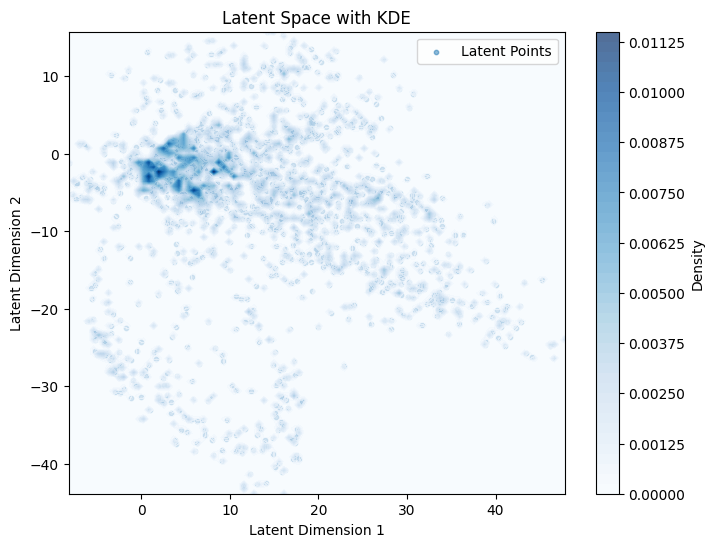

In [ ]:
# Visualize latent space and PDF
plot_latent_space(latent_data, kde=kde)

In [ ]:
# Generate new images
generated_images = sample_and_decode(kde, decoder, n_samples=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


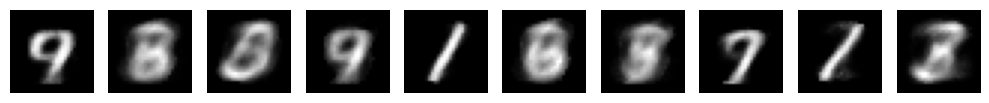

In [ ]:
# Visualize generated images
fig, axes = plt.subplots(1, len(generated_images), figsize=(10, 5))
for i, img in enumerate(generated_images):
    axes[i].imshow(img.reshape(28, 28), cmap='gray')
    axes[i].axis('off')
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

## Restricted Boltzmann Machines

In [ ]:
# Define the RBM class
class RBM:
    def __init__(self, n_visible, n_hidden):
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        # Initialize weights and biases
        self.W = np.random.normal(0, 0.01, size=(n_hidden, n_visible))  # Weight matrix
        self.b = np.zeros(n_visible)  # Bias for visible layer
        self.c = np.zeros(n_hidden)  # Bias for hidden layer

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample_hidden(self, visible):
        # Calculate hidden activations
        activation = np.dot(visible, self.W.T) + self.c
        probabilities = self.sigmoid(activation)
        hidden_states = (probabilities > np.random.rand(*probabilities.shape)).astype(np.float32)
        return hidden_states, probabilities

    def sample_visible(self, hidden):
        # Calculate visible activations
        activation = np.dot(hidden, self.W) + self.b
        probabilities = self.sigmoid(activation)
        visible_states = (probabilities > np.random.rand(*probabilities.shape)).astype(np.float32)
        return visible_states, probabilities

    def contrastive_divergence(self, input_data, lr=0.1, k=1):
        # Positive phase
        hidden_states, hidden_probs = self.sample_hidden(input_data)

        # Negative phase
        visible_recon = input_data.copy()
        for _ in range(k):
            visible_recon, _ = self.sample_visible(hidden_states)
            hidden_states, hidden_probs = self.sample_hidden(visible_recon)

        # Compute weight updates
        positive_grad = np.dot(hidden_probs.T, input_data)
        negative_grad = np.dot(hidden_probs.T, visible_recon)

        # Update weights and biases
        self.W += lr * (positive_grad - negative_grad) / input_data.shape[0]
        self.b += lr * np.mean(input_data - visible_recon, axis=0)
        self.c += lr * np.mean(hidden_probs - hidden_states, axis=0)

    def reconstruct(self, visible, k=1):
        # Perform Gibbs sampling to reconstruct visible data
        hidden_states, _ = self.sample_hidden(visible)
        for _ in range(k):
            visible, _ = self.sample_visible(hidden_states)
            hidden_states, _ = self.sample_hidden(visible)
        return visible

In [ ]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1).numpy())])
mnist_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
data_loader = DataLoader(mnist_data, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 21.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 684kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 5.55MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.42MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Initialize RBM
n_visible = 784  # 28x28 pixels flattened
n_hidden = 128
rbm = RBM(n_visible, n_hidden)

In [ ]:
# Train the RBM
epochs = 20
for epoch in range(epochs):
    for batch_idx, (batch, _) in enumerate(data_loader):
        rbm.contrastive_divergence(batch.numpy())
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch + 1}, Batch {batch_idx}")

Epoch 1, Batch 0
Epoch 1, Batch 100
Epoch 1, Batch 200
Epoch 1, Batch 300
Epoch 1, Batch 400
Epoch 1, Batch 500
Epoch 1, Batch 600
Epoch 1, Batch 700
Epoch 1, Batch 800
Epoch 1, Batch 900
Epoch 2, Batch 0
Epoch 2, Batch 100
Epoch 2, Batch 200
Epoch 2, Batch 300
Epoch 2, Batch 400
Epoch 2, Batch 500
Epoch 2, Batch 600
Epoch 2, Batch 700
Epoch 2, Batch 800
Epoch 2, Batch 900
Epoch 3, Batch 0
Epoch 3, Batch 100
Epoch 3, Batch 200
Epoch 3, Batch 300
Epoch 3, Batch 400
Epoch 3, Batch 500
Epoch 3, Batch 600
Epoch 3, Batch 700
Epoch 3, Batch 800
Epoch 3, Batch 900
Epoch 4, Batch 0
Epoch 4, Batch 100
Epoch 4, Batch 200
Epoch 4, Batch 300
Epoch 4, Batch 400
Epoch 4, Batch 500
Epoch 4, Batch 600
Epoch 4, Batch 700
Epoch 4, Batch 800
Epoch 4, Batch 900
Epoch 5, Batch 0
Epoch 5, Batch 100
Epoch 5, Batch 200
Epoch 5, Batch 300
Epoch 5, Batch 400
Epoch 5, Batch 500
Epoch 5, Batch 600
Epoch 5, Batch 700
Epoch 5, Batch 800
Epoch 5, Batch 900
Epoch 6, Batch 0
Epoch 6, Batch 100
Epoch 6, Batch 200
Epoch

In [ ]:
# Generate new images
samples = []
for _ in range(10):
    noise = np.random.rand(1, n_visible)  # Start with random noise
    generated_image = rbm.reconstruct(noise, k=1000).reshape(28, 28)
    samples.append(generated_image)

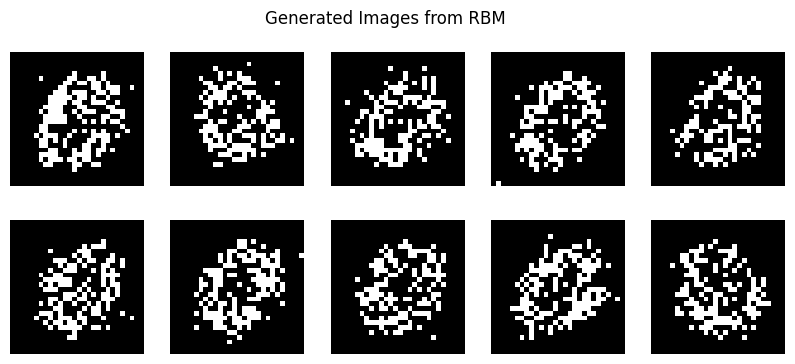

In [ ]:
# Plot the generated images
plt.figure(figsize=(10, 4))
for i, sample in enumerate(samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample, cmap="gray")
    plt.axis("off")
plt.suptitle("Generated Images from RBM")
plt.show()

## Restricted Boltzmann Machines & AutoEncoder

In [130]:
# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

In [131]:
# Normalize data and flatten it
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

In [132]:
# Define Autoencoder
input_dim = 28 * 28
encoding_dim = 2

# Build the autoencoder
input_img = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = models.Model(input_img, decoded)
encoder = models.Model(input_img, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(x_train, x_train, epochs=10, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.5278 - val_loss: 0.2809
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2779 - val_loss: 0.2649
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2609 - val_loss: 0.2522
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2516 - val_loss: 0.2480
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2485 - val_loss: 0.2454
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2460 - val_loss: 0.2434
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2437 - val_loss: 0.2418
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2425 - val_loss: 0.2407
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2421 - val_loss: 0.2398
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2406 - val_loss: 0.2388


In [133]:
# Reduce dimensionality of training data
x_train_encoded = encoder.predict(x_train)
x_test_encoded = encoder.predict(x_test)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [134]:
# Rescale encoded data to [0, 1] for RBM
scaler = MinMaxScaler()
x_train_encoded = scaler.fit_transform(x_train_encoded)
x_test_encoded = scaler.transform(x_test_encoded)

In [135]:
# Define RBM
rbm = BernoulliRBM(n_components=encoding_dim, learning_rate=0.01, n_iter=20, random_state=42)
pipeline = Pipeline(steps=[("rbm", rbm)])

In [136]:
# Train RBM
pipeline.fit(x_train_encoded)

Pipeline(steps=[('rbm',
                 BernoulliRBM(learning_rate=0.01, n_components=2, n_iter=20,
                              random_state=42))])

In [137]:
n_samples = 10  # Number of samples to generate
generated_samples = rbm.gibbs(np.random.rand(n_samples, rbm.n_components))

In [138]:
# Rescale samples back to [0, 1] and reshape
reconstructed_samples = scaler.inverse_transform(generated_samples)
reconstructed_samples = autoencoder.layers[-1](reconstructed_samples).numpy()
reconstructed_samples = reconstructed_samples.reshape(-1, 28, 28)

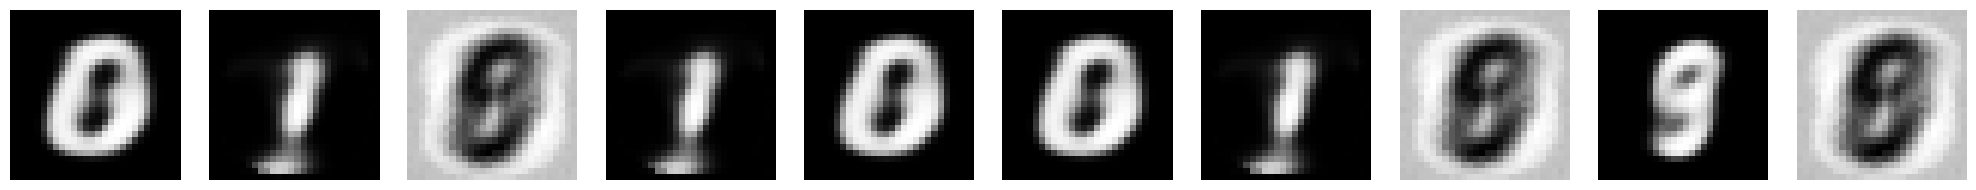

In [139]:
# Plot generated images
def plot_images(images, ncols=10, nrows=1):
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(reconstructed_samples)

## Markov Random Fields

In [189]:
# 1. Load MNIST data
(x_train, _), (x_test, _) = mnist.load_data()
x_test = x_test.astype(np.float32) / 255.0  # Normalize to [0, 1]

In [190]:
# Select an image and add noise
np.random.seed(42)
original_image = x_test[0]  # Use the first test image
noisy_image = original_image + 0.1 * np.random.randn(*original_image.shape)
noisy_image = np.clip(noisy_image, 0, 1)  # Keep within [0, 1]

In [191]:
# 2. Define MRF Parameters
def energy(x, y, beta=1.0, sigma=0.1):
    """Compute the energy of the current state."""
    # Data term (likelihood): similarity to noisy image
    data_term = np.sum((y - x) ** 2) / (2 * sigma**2)

    # Smoothness term (prior): differences between neighbors
    smoothness_term = 0
    smoothness_term += np.sum((x[1:, :] - x[:-1, :]) ** 2)  # Vertical neighbors
    smoothness_term += np.sum((x[:, 1:] - x[:, :-1]) ** 2)  # Horizontal neighbors
    smoothness_term *= beta

    return data_term + smoothness_term

In [192]:
def denoise_mrf(noisy, iterations=50, beta=1.0, sigma=0.1):
    """Denoise the image using MRF."""
    denoised = noisy.copy()
    for _ in range(iterations):
        for i in range(1, denoised.shape[0] - 1):
            for j in range(1, denoised.shape[1] - 1):
                # Neighborhood pixels
                neighbors = [
                    denoised[i - 1, j], denoised[i + 1, j],
                    denoised[i, j - 1], denoised[i, j + 1]
                ]
                # Update the pixel by minimizing the local energy
                mean_neighbors = np.mean(neighbors)
                denoised[i, j] = (noisy[i, j] / sigma**2 + beta * mean_neighbors) / (1 / sigma**2 + 4 * beta)
    return denoised

In [193]:
# 3. Perform Denoising
beta = 0.1  # Strength of smoothness
sigma = 0.1  # Noise level
iterations = 2000

In [194]:
denoised_image = denoise_mrf(noisy_image, iterations=iterations, beta=beta, sigma=sigma)

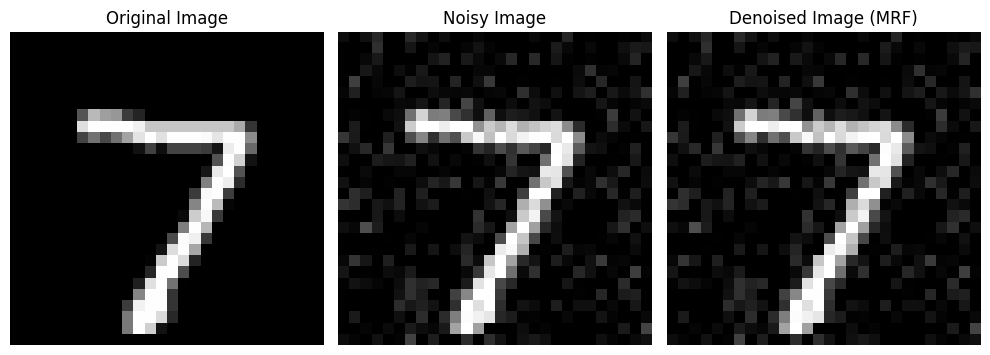

In [195]:
# 4. Display the Results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Noisy Image")
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f"Denoised Image (MRF)")
plt.imshow(denoised_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

## Simulated Annealing

### Toy Model in One Dimension

In [196]:
# Objective function
def objective(x):
    return x**4 - 3*x**3 + 2

In [197]:
# Simulated annealing
def simulated_annealing(func, bounds, T0, alpha, max_iter):
    x_current = np.random.uniform(*bounds)  # Random initial solution
    f_current = func(x_current)
    x_best = x_current
    f_best = f_current
    T = T0  # Initial temperature

    history = [(x_current, f_current)]

    for i in range(max_iter):
        # Generate a new candidate solution
        x_new = x_current + np.random.uniform(-0.5, 0.5)
        x_new = np.clip(x_new, *bounds)  # Keep within bounds
        f_new = func(x_new)

        # Acceptance criterion
        delta_f = f_new - f_current
        if delta_f < 0 or np.random.rand() < np.exp(-delta_f / T):
            x_current = x_new
            f_current = f_new

        # Update the best solution
        if f_current < f_best:
            x_best = x_current
            f_best = f_current

        # Store history for plotting
        history.append((x_current, f_current))

        # Update temperature
        T *= alpha

    return x_best, f_best, history

In [198]:
# Parameters
bounds = [-2, 3]  # Search space
T0 = 10  # Initial temperature
alpha = 0.95  # Cooling factor
max_iter = 1000  # Number of iterations

In [199]:
# Run simulated annealing
x_opt, f_opt, history = simulated_annealing(objective, bounds, T0, alpha, max_iter)

In [200]:
# Extract history for plotting
x_hist, f_hist = zip(*history)

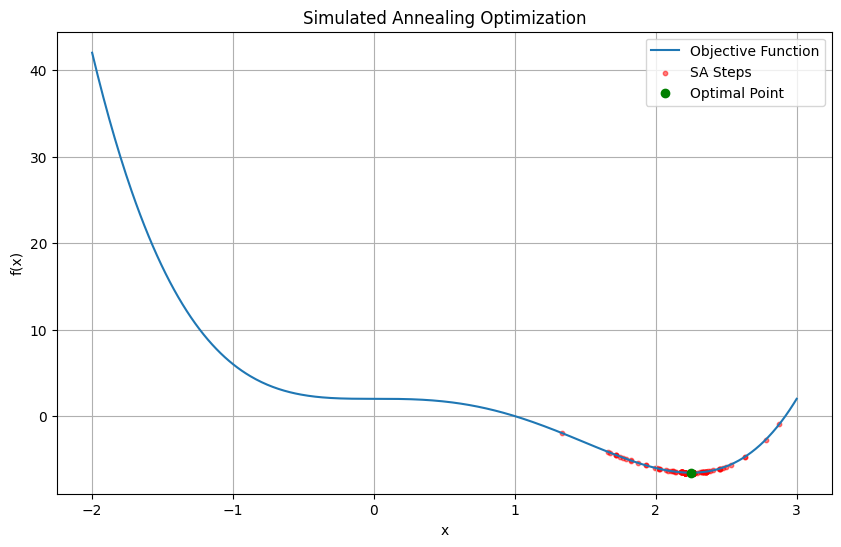

In [201]:
# Plotting
x_vals = np.linspace(*bounds, 500)
y_vals = objective(x_vals)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label="Objective Function")
plt.scatter(x_hist, f_hist, color="red", s=10, label="SA Steps", alpha=0.5)
plt.scatter(x_opt, f_opt, color="green", label="Optimal Point", zorder=5)
plt.title("Simulated Annealing Optimization")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()
plt.show()

### Model MNIST Dataset

In [208]:
# Load MNIST dataset
(_, _), (x_test, y_test) = mnist.load_data()
x_test = x_test / 255.0  # Normalize to [0, 1]

In [209]:
# Pre-trained classifier (optional, replace with your model or skip)
# Here we'll simulate a simple classifier's "confidence" score
def fake_classifier_confidence(image, target_label):
    """Simulated confidence score for target_label."""
    # Placeholder for classifier (e.g., similarity to a prototype digit)
    prototype = np.mean(x_test[y_test == target_label], axis=0)
    return -np.sum((image - prototype)**2)  # Negative MSE as similarity

In [210]:
# Simulated annealing for MNIST-like image generation
def generate_image_sa(target_label, T0, alpha, max_iter):
    img_dim = (28, 28)
    current_image = np.random.rand(*img_dim)  # Random initial image
    current_score = fake_classifier_confidence(current_image, target_label)

    best_image = current_image.copy()
    best_score = current_score
    T = T0  # Initial temperature

    history = [current_score]

    for _ in range(max_iter):
        # Generate a neighboring image
        new_image = current_image + np.random.normal(0, 0.1, size=img_dim)
        new_image = np.clip(new_image, 0, 1)  # Keep within [0, 1]
        new_score = fake_classifier_confidence(new_image, target_label)

        # Acceptance criterion
        delta_score = new_score - current_score
        if delta_score > 0 or np.random.rand() < np.exp(delta_score / T):
            current_image = new_image
            current_score = new_score

        # Update the best image
        if current_score > best_score:
            best_image = current_image.copy()
            best_score = current_score

        # Record history
        history.append(current_score)

        # Update temperature
        T *= alpha

    return best_image, best_score, history

In [211]:
# Parameters
target_label = 0  # Generate an image resembling digit "0"
T0 = 10  # Initial temperature
alpha = 0.95  # Cooling factor
max_iter = 5000  # Number of iterations

In [212]:
# Generate image
generated_image, final_score, score_history = generate_image_sa(target_label, T0, alpha, max_iter)

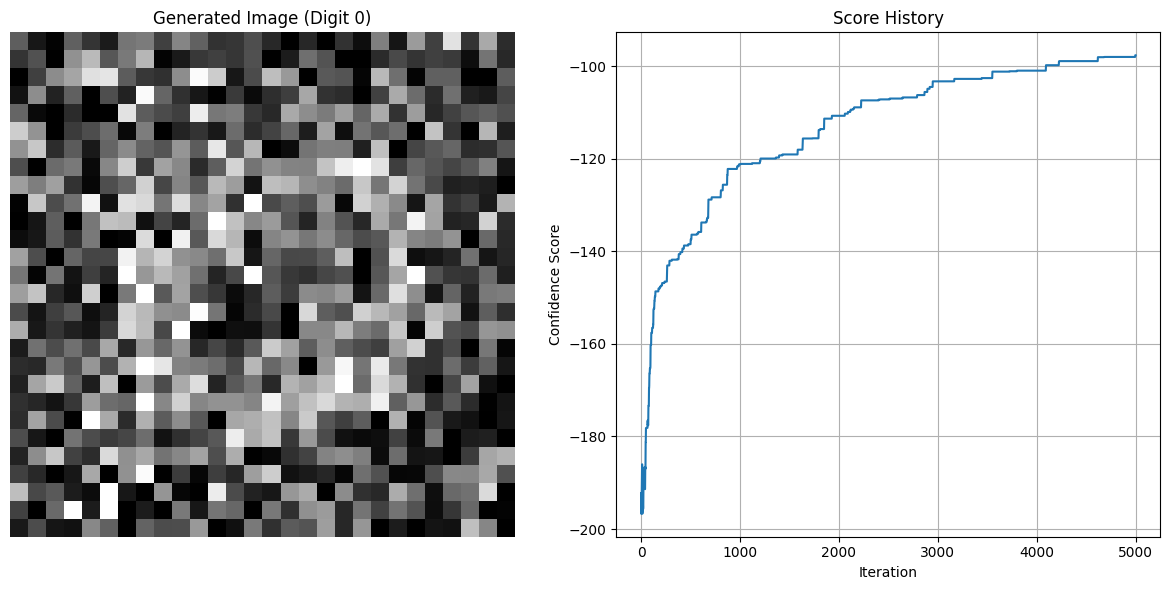

In [213]:
# Plot results
plt.figure(figsize=(12, 6))

# Generated image
plt.subplot(1, 2, 1)
plt.imshow(generated_image, cmap='gray')
plt.title(f"Generated Image (Digit {target_label})")
plt.axis('off')

# Score history
plt.subplot(1, 2, 2)
plt.plot(score_history)
plt.title("Score History")
plt.xlabel("Iteration")
plt.ylabel("Confidence Score")
plt.grid()

plt.tight_layout()
plt.show()

## Self-Organizing Map

In [214]:
# Load MNIST data
(x_train, y_train), (_, _) = mnist.load_data()

# Flatten the images and normalize to [0, 1]
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0

In [215]:
# Parameters for the SOM
som_width = 20  # Width of the SOM grid
som_height = 20  # Height of the SOM grid
input_len = x_train.shape[1]  # Length of each data vector (784 for MNIST)
sigma = 1.0  # Neighborhood radius
learning_rate = 0.5  # Initial learning rate

In [216]:
# Initialize the SOM
som = MiniSom(som_height, som_width, input_len, sigma=sigma, learning_rate=learning_rate)
som.random_weights_init(x_train)
# Train the SOM
print("Training SOM...")
som.train_random(x_train, 10000)  # Train for 10,000 iterations
print("SOM training completed!")

Training SOM...
SOM training completed!


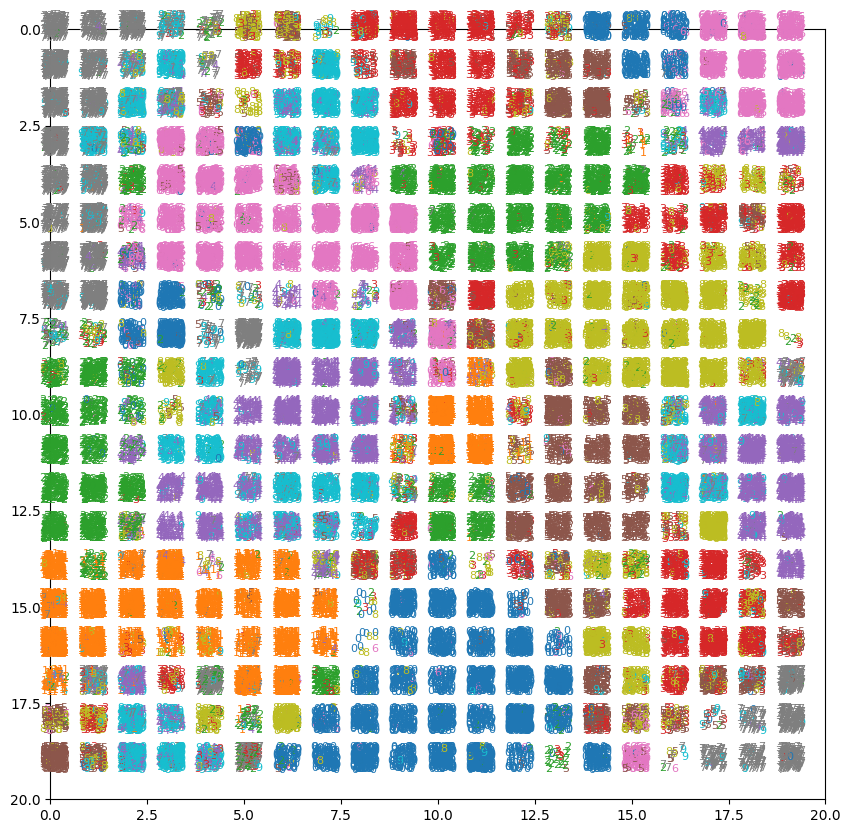

In [217]:
# Visualize the SOM with class labels
plt.figure(figsize=(10, 10))
for i, (x, y) in enumerate(zip(x_train, y_train)):
    winner = som.winner(x)  # Get the BMU for each sample
    plt.text(winner[1] + np.random.rand() * 0.6 - 0.3,  # Jitter x for better visualization
             winner[0] + np.random.rand() * 0.6 - 0.3,  # Jitter y
             str(y), color=plt.cm.tab10(y / 10.0), fontdict={'size': 8})
plt.xlim([0, som_width])
plt.ylim([0, som_height])
plt.gca().invert_yaxis()
plt.show()

## Autoregressive

### Toy Model

In [218]:
# Generate synthetic AR(2) data
np.random.seed(42)
n = 100
phi1, phi2 = 0.6, -0.3
noise = np.random.normal(0, 1, n)
data = np.zeros(n)
for t in range(2, n):
    data[t] = phi1 * data[t-1] + phi2 * data[t-2] + noise[t]

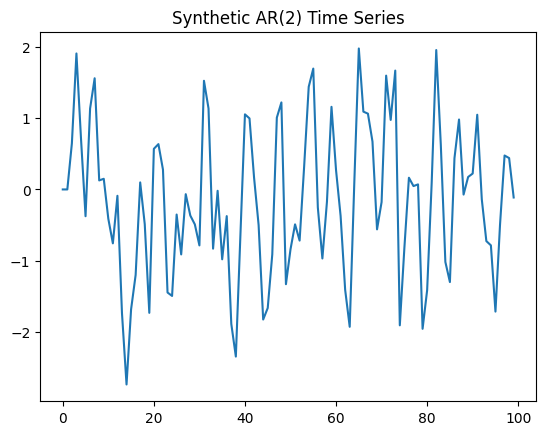

In [219]:
# Plot the time series
plt.plot(data)
plt.title("Synthetic AR(2) Time Series")
plt.show()

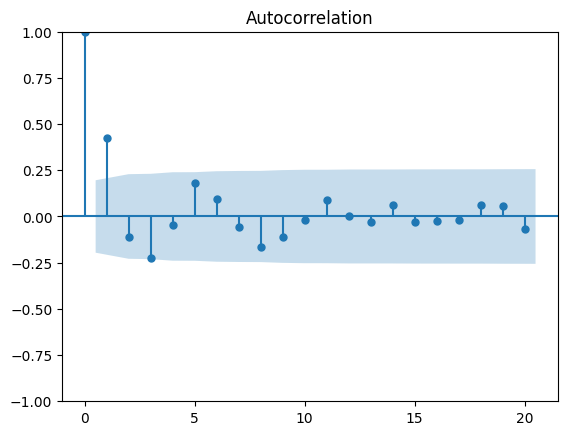

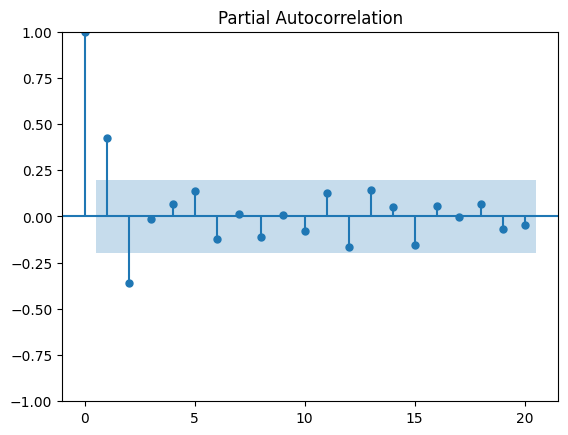

In [220]:
# Plot ACF and PACF
plot_acf(data, lags=20)
plot_pacf(data, lags=20)
plt.show()

In [221]:
# Fit AR model
model = AutoReg(data, lags=2)
result = model.fit()
print(result.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  100
Model:                     AutoReg(2)   Log Likelihood                -129.560
Method:               Conditional MLE   S.D. of innovations              0.908
Date:                Sat, 14 Dec 2024   AIC                            267.119
Time:                        21:30:25   BIC                            277.459
Sample:                             2   HQIC                           271.301
                                  100                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1220      0.093     -1.311      0.190      -0.304       0.060
y.L1           0.5800      0.094      6.149      0.000       0.395       0.765
y.L2          -0.3590      0.094     -3.801      0.0

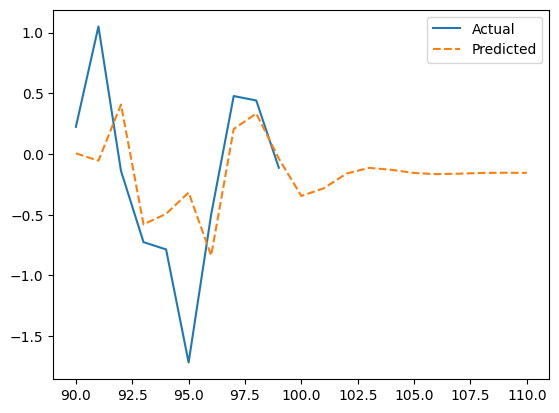

In [222]:
# Predict and plot
predictions = result.predict(start=90, end=110)  # Forecasting 20 steps ahead
plt.plot(range(90, 100), data[90:100], label='Actual')
plt.plot(range(90, 111), predictions, label='Predicted', linestyle='--')
plt.legend()
plt.show()

### PixelCNN

In [9]:
# Load a dataset (e.g., MNIST)
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0  # Normalize
x_train = np.expand_dims(x_train, axis=-1)   # Add channel dimension

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Define PixelCNN model
class PixelCNN(tf.keras.Model):
    def __init__(self, num_filters=64):
        super(PixelCNN, self).__init__()
        self.conv1 = layers.Conv2D(num_filters, (7, 7), padding="same", activation='relu')
        self.conv2 = layers.Conv2D(num_filters, (7, 7), padding="same", activation='relu')
        self.conv3 = layers.Conv2D(1, (1, 1), activation='sigmoid')  # Output layer

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        return self.conv3(x)

In [11]:
# Instantiate and compile the model
pixel_cnn = PixelCNN()
pixel_cnn.compile(optimizer='adam', loss='binary_crossentropy')

In [17]:
# Train the model
pixel_cnn.fit(x_train, x_train, epochs=20, batch_size=64)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0610
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0601
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.0597
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0595
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0593
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0591
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0591
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0590
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0590
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0588
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0588
Epoch 12/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0587
Epoch 13/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0586
Epoch 14/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0587
Epoch 15/20
938/938 ━━━━━━━━━

In [18]:
# Suppress TensorFlow warnings temporarily
def suppress_tf_logs():
    logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Function to generate an image
def generate_image(model, img_shape):
    img = np.zeros(img_shape, dtype=np.float32)
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            for c in range(img_shape[2]):
                suppress_tf_logs()  # Suppress logs during model.predict
                prob = model.predict(img[None, :, :, :], verbose=0)[0, i, j, c]
                img[i, j, c] = np.random.choice([0, 1], p=[1-prob, prob])
    return img

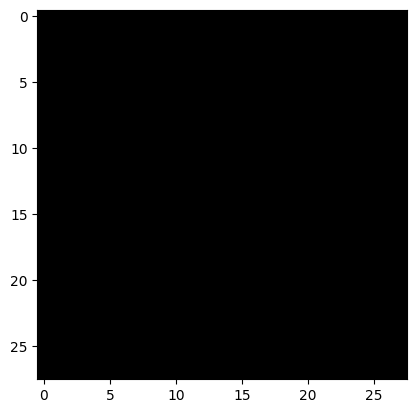

In [19]:
# Generate and visualize
generated_img = generate_image(pixel_cnn, (28, 28, 1))
plt.imshow(generated_img.squeeze(), cmap='gray')
plt.show()

### PixelRNN

In [21]:
# Load dataset (e.g., MNIST)
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0  # Normalize to [0, 1]
x_train = np.expand_dims(x_train, axis=-1)   # Add channel dimension

In [25]:
x_train.shape

(60000, 28, 28, 1)

In [28]:
# Define PixelRNN model
class PixelRNN(tf.keras.Model):
    def __init__(self, num_units=128):
        super(PixelRNN, self).__init__()
        self.rnn1 = layers.ConvLSTM2D(filters=num_units, kernel_size=(3, 3), padding="same", return_sequences=True)
        self.rnn2 = layers.ConvLSTM2D(filters=num_units, kernel_size=(3, 3), padding="same", return_sequences=True)
        self.conv_out = layers.Conv2D(1, (1, 1), activation='sigmoid')  # Final output layer

    def call(self, inputs):
        x = self.rnn1(inputs)
        x = self.rnn2(x)
        return self.conv_out(x)

In [27]:
# Instantiate and compile the model
pixel_rnn = PixelRNN()
pixel_rnn.compile(optimizer='adam', loss='binary_crossentropy')

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'ConvLSTM'

In [ ]:
# Train the model
pixel_rnn.fit(x_train, x_train, epochs=5, batch_size=64)

In [ ]:
# Generate new images
def generate_image_rnn(model, img_shape):
    img = np.zeros(img_shape, dtype=np.float32)
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            for c in range(img_shape[2]):
                prob = model.predict(img[None, :, :, :])[0, i, j, c]
                img[i, j, c] = np.random.choice([0, 1], p=[1 - prob, prob])
    return img

In [ ]:
# Generate and visualize
generated_img = generate_image_rnn(pixel_rnn, (28, 28, 1))
plt.imshow(generated_img.squeeze(), cmap='gray')
plt.title("Generated Image (PixelRNN)")
plt.show()

### Autoregressive Transformers for Image Generation

In [29]:
# Load dataset (e.g., MNIST)
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0  # Normalize
x_train = np.expand_dims(x_train, axis=-1)   # Add channel dimension
x_train = x_train.reshape(-1, 28 * 28)       # Flatten images

In [30]:
# Define Autoregressive Transformer
class AutoregressiveTransformer(tf.keras.Model):
    def __init__(self, vocab_size=256, seq_len=784, embed_dim=128, num_heads=8, num_layers=4):
        super(AutoregressiveTransformer, self).__init__()
        self.embedding = layers.Embedding(vocab_size, embed_dim)
        self.positional_encoding = layers.Embedding(seq_len, embed_dim)
        self.transformer_blocks = [
            layers.TransformerBlock(embed_dim, num_heads, feed_forward_dim=embed_dim * 4)
            for _ in range(num_layers)
        ]
        self.dense = layers.Dense(vocab_size, activation='softmax')

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        x = self.embedding(inputs) + self.positional_encoding(positions)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        return self.dense(x)

In [ ]:
# Instantiate the model
vocab_size = 256  # 256 grayscale levels
model = AutoregressiveTransformer(vocab_size=vocab_size, seq_len=28 * 28)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [ ]:
# Train the model
x_train_int = (x_train * 255).astype('int32')  # Convert to integers
model.fit(x_train_int, x_train_int, epochs=5, batch_size=64)

In [ ]:
# Generate new images
def generate_image_transformer(model, img_shape):
    seq_len = img_shape[0] * img_shape[1]
    generated_seq = np.zeros((1, seq_len), dtype='int32')
    for i in range(seq_len):
        logits = model.predict(generated_seq)
        next_pixel = np.random.choice(vocab_size, p=logits[0, i])
        generated_seq[0, i] = next_pixel
    return generated_seq.reshape(img_shape)

In [ ]:
# Generate and visualize
generated_img = generate_image_transformer(model, (28, 28))
plt.imshow(generated_img, cmap='gray')
plt.title("Generated Image (Autoregressive Transformer)")
plt.show()